# README

## Implementation Notes

I made several changes compared to the implementation based on the lectures and starter code, as described below.

### Avoid explicit inverses

Instead, use LU solve. This should be more numerically stable. It also seems to improve performance by 5%-10% on dataset 1, even though the matrices are very small.

This also required some modifications to the code that computes the normalised innovation squared (NIS) score after updates, to avoid using $S^{-1}$ explicitly. See notes in the code for details.

### Refactor the code to use fixed-size matrices

Eigen provides both fixed and dynamic-sized matrices; fixed size matrices provide more compile-time correctness checking and should in principle be faster by allowing the compiler to do more optimisation.

To use fixed size matrices, I extended the template classes that I wrote for the first project, Extended Kalman Filters, to implement a UKF. The `UnscentedKalmanFilter` template class and its contained `Sensor` template classes contain a generic UKF implementation, and the `UKF` class contains the logic specific to the CTRV model.

The refactored code was about 15% faster than the baseline. In addition to using fixed-size matrices, I also made some other improvements, such as combining the two loops in the radar update and re-using the LU factorisation for the update to calculate the NIS score, which may have contributed to the improved performance.

### Detect if $P$ is not positive semidefinite

The calculation of the covariance matrix from the sigma points can result in a non-positive semidefinite estimate for the state covariance matrix, $P$, when the spreading parameter $\lambda$ is negative. The [Julier and Uhlmannn](http://jimbeck.caltech.edu/summerlectures/references/Unscented%20Kalman%20filter.pdf) paper also mentions this problem and that there are workarounds.

For now, I've just added a check to the Cholesky factorization step: Cholesky factorization will fail if the matrix is non-positive semidefinite. For most (but certainly not all) initializations and parameter settings, we avoid this numerical failure for the two test datasets.

### Initialization

The lidar and radar initialization (as I have implemented them) require initial estimates for variances of the speed, yaw and yaw rate. I set these to give standard deviations of 5m/s, $\pi/4$ radians and $\pi/8$ radians / second, respectively, which seem like reasonable prior values for tracking a pedestrian.

The choice of $\pi/4$ for the initial variance of $\phi$ biases the filter toward angles in the first and fourth quadrants (along the positive x axis). I think this is beneficial, because the filter can still represent yaw angles in second and third quadrants (along the negative x axis) using a negative speed. By doing so, it avoids the nonlinearity for angles near $\pm\pi$ --- they switch sign when crossing the negative x axis, due to angle normalization.

The position uncertainties for the lidar and radar are both calculated based on the measurement uncertainty for the first measurement.

### Parameter Tuning

The three main tunable parameters are the process noise in acceleration, the process noise in yaw acceleration, and the spreading parameter $\lambda$. The workbook below shows the results of some parameter sweeps.

To evaluate the solutions, we are interested in (1) the RMSEs obtained and (2) the consistency of the filter. As a metric for consistency, I used the Kullback-Leibler divergence between the theoretical $\chi^2$ distribution and the observed empirical solution; if the filter is consistent, this divergence should be small. Since we have multiple objectives, it is useful to find the Pareto frontier to choose between non-dominated solutions.

This process did not identify any setting of the three parameters that produced both good tracking (low RMSEs) and high consistency for both datasets. However, it did identify many solutions that met the RMSE specifications for this project. I have used one of the solutions from the Pareto frontier as the default parameters for the `UnscentedKF` program; the results for this set are plotted below.

## Setup

In [1]:
%matplotlib inline

In [2]:
import itertools
import math
import pickle
import subprocess
from io import StringIO
from os import path
from tempfile import TemporaryDirectory

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
from scipy.stats import chi2, entropy

## Results with Chosen Default Parameters

Run the `UnscentedKF` application with the default parameter values and plot the output.

The parameter values were determined using the grid search below. As noted above, none of the grid solutions produced particularly good consistency (in terms of NIS) for both datasets simultaneously, but overall the tracking is good --- RMSEs are low.

In [3]:
def data_path(set_number):
    return 'data/sample-laser-radar-measurement-data-{}.txt'.format(set_number)

def run(set_number, use_laser=None, use_radar=None,
        std_a=None, std_yawdd=None, lambd=None):
    with TemporaryDirectory() as tmp:
        output_path = path.join(tmp, 'output.txt')
        command = [
          'build/UnscentedKF',
          data_path(set_number),
          output_path,
          'true', # tweak output for reading by this tool
        ]
        if use_laser is not None:
            command += [
              str(use_laser).lower(),
              str(use_radar).lower(),
              str(std_a),
              str(std_yawdd),
              str(lambd)
            ]
        result = subprocess.run(
          command,
          stdout=subprocess.PIPE,
          stderr=subprocess.PIPE,
          universal_newlines=True
        )
        with open(output_path, 'r') as output_file:
            return result, output_file.read()

set number:  1 : RMSEs:  [0.071172, 0.0880705, 0.588174, 0.586496]
set number:  2 : RMSEs:  [0.181637, 0.188999, 0.364263, 0.478872]


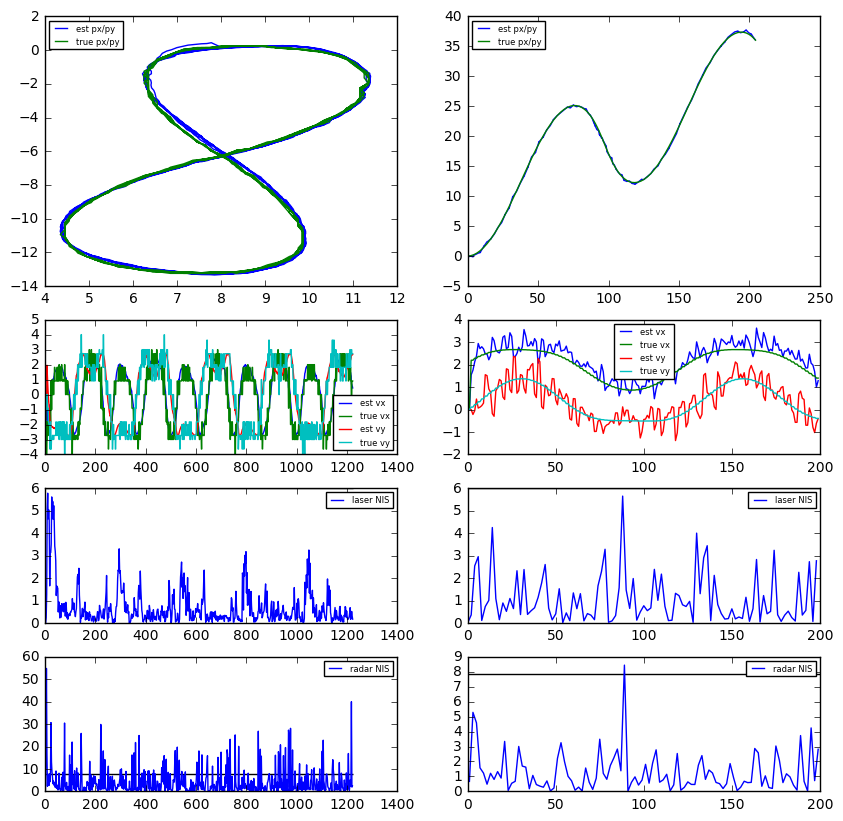

In [4]:
def extract_rmse(result):
    # Since we've already computed the RMSEs, just extract them from stdout.
    if result.returncode != 0:
        return None
    lines = result.stdout.splitlines()
    rmse_start = lines.index('Accuracy - RMSE:') + 1
    rmse_end = rmse_start + 4
    return [float(rmse) for rmse in lines[rmse_start:rmse_end]]

def run_and_process(**params):
    result, output = run(**params)
    assert result.returncode == 0
    return extract_rmse(result), pd.read_table(StringIO(output))

def plot_output():
    fig, axes = plt.subplots(
        4, 2,
        figsize=(10, 10),
        gridspec_kw={'height_ratios':[2, 1, 1, 1]}
    )
    for set_number in [1, 2]:
        rmse, df = run_and_process(set_number=set_number)
        print('set number: ', set_number, ': RMSEs: ', rmse)
        
        df['vx'] = df['v'] * np.cos(df['yaw_angle'])
        df['vy'] = df['v'] * np.sin(df['yaw_angle'])
        
        ax = axes[0][set_number - 1]
        ax.plot(df['px'], df['py'], label='est px/py')
        ax.plot(df['px_true'], df['py_true'], label='true px/py')
        ax.legend(loc='best', prop={'size': 6})
        
        ax = axes[1][set_number - 1]
        ax.plot(df['vx'], label='est vx')
        ax.plot(df['vx_true'], label='true vx')
        ax.plot(df['vy'], label='est vy')
        ax.plot(df['vy_true'], label='true vy')
        ax.legend(loc='best', prop={'size': 6})
        
        ax = axes[2][set_number - 1]
        ax.plot(df[df.sensor == 'L']['NIS'], label='laser NIS')
        ax.hlines(chi2.ppf(0.95, 2), 0, len(df.index))
        ax.legend(loc='best', prop={'size': 6})

        ax = axes[3][set_number - 1]
        ax.plot(df[df.sensor == 'R']['NIS'], label='radar NIS')
        ax.hlines(chi2.ppf(0.95, 3), 0, len(df.index))
        ax.legend(loc='best', prop={'size': 6})
        
plot_output()

## Grid Search for Parameters

### Metrics of Consistency

In [5]:
#
# This is the NIS score test suggested in the lecture: find the expected NIS
# based on the 95th percentile of the Chi^2 distribution with the relevant
# number of degrees of freedom (e.g. NIS ~ 7.8 for 3 DoF). Then find the
# percentage of observed NIS scores that are below that threshold. If the answer
# is close to 95%, that suggests that the filter is consistent.
#
def find_nis_quantile(nis_scores, df, quantile=0.95):
    if len(nis_scores) == 0: return float('nan')
    threshold = chi2.ppf(quantile, df)
    return sum(nis < threshold for nis in nis_scores) / len(nis_scores)

# Check: this number should be about 0.95
find_nis_quantile(chi2.rvs(2, size=1000), 2)

0.95499999999999996

In [6]:
#
# Compute the Kullback–Leibler divergence between the empirical distribution
# of NIS scores and the Chi^2 distribution with the given number of degrees of
# freedom. If the empirical distribution of the NIS scores is close to the
# expected Chi^2 distribution, so the filter is consistent, then the returned
# KL-div will be small.
#
def find_nis_kl_div(nis_scores, df, num_bins=21):
    if len(nis_scores) == 0: return float('nan')
    if not np.all(np.isfinite(nis_scores)): return float('nan')
    # Pick the bins so that we expect an equal mass in each bin, according to
    # the Chi^2 distribution with the appropriate number of degrees of freedom.
    xs = np.linspace(0, 1, num_bins)
    pk, _ = np.histogram(nis_scores, bins=chi2.ppf(xs, df))
    pk = pk.astype(np.double) / np.sum(pk)
    qk = np.diff(xs)
    return entropy(pk, qk)

# Check: this number should be near zero.
find_nis_kl_div(chi2.rvs(2, size=1000), 2)

0.0077898738206822124

### Search

Before the search grid below, I ran a search grid with a wider range for the parameters:

```
'std_a': np.linspace(0.1, 10, 20).tolist(),
'std_yawdd': (math.pi / np.linspace(0.1, 10, 20)).tolist(),
'lambd': np.linspace(-10, 10, 40).tolist()
```

The region of the parameter space with solutions with RMSEs that met the specifications for this project was fortunately compact, so the grid below intensifies the search in that region.

In [7]:
# From http://stackoverflow.com/a/40623158/2053820
def dict_product(dicts):
    """
    >>> list(dict_product(dict(number=[1,2], character='ab')))
    [{'character': 'a', 'number': 1},
     {'character': 'a', 'number': 2},
     {'character': 'b', 'number': 1},
     {'character': 'b', 'number': 2}]
    """
    return (dict(zip(dicts, x)) for x in itertools.product(*dicts.values()))

In [8]:
SENSOR_INDEX = 11
NIS_INDEX = 12

def check_output_header_line(line):
    fields = line.split()
    assert len(fields) == 13
    assert fields[SENSOR_INDEX] == 'sensor'
    assert fields[NIS_INDEX] == 'NIS'

def extract_nis(output):
    output = output.splitlines()
    check_output_header_line(output[0])
    rows = [
        output[i].split()
        for i in range(1, len(output))
    ]
    return [
        [float(row[NIS_INDEX]) for row in rows if row[SENSOR_INDEX] == sensor]
        for sensor in ['L', 'R'] 
    ]

def evaluate(params):
    result, output = run(**params)
    if result.returncode == 0:
        rmse = extract_rmse(result)
        laser_nis_scores, radar_nis_scores = extract_nis(output)
    else:
        rmse = [float('inf')] * 4
        laser_nis_scores = []
        radar_nis_scores = []

    laser_df = 2
    radar_df = 3
    return {
        'px_rmse': rmse[0],
        'py_rmse': rmse[1],
        'vx_rmse': rmse[2],
        'vy_rmse': rmse[3],
        'laser_nis_kl_div': find_nis_kl_div(laser_nis_scores, laser_df),
        'laser_nis_quantile': find_nis_quantile(laser_nis_scores, laser_df),
        'radar_nis_kl_div': find_nis_kl_div(radar_nis_scores, radar_df),
        'radar_nis_quantile': find_nis_quantile(radar_nis_scores, radar_df)
    }

In [9]:
RESULTS_FILE = 'data/search.pickle'

In [10]:
def search():
    if path.isfile(RESULTS_FILE):
        with open(RESULTS_FILE, 'rb') as f:
            results = pickle.load(f)
    else:
        results = {}

    keys = {
        'set_number': [1, 2],
        'use_laser': [True],
        'use_radar': [True],
        'std_a': np.linspace(0.2, 2.0, 20).tolist(),
        'std_yawdd': (math.pi / np.linspace(4.0, 8.0, 20)).tolist(),
        'lambd': np.linspace(-6, -1, 20).tolist()
    }

    for key in dict_product(keys):
        frozen_key = frozenset(key.items())
        if frozen_key in results:
            continue

        results[frozen_key] = evaluate(key)

        with open(RESULTS_FILE, 'wb') as f:
            pickle.dump(results, f, pickle.HIGHEST_PROTOCOL)

search()

### Grid Search Results

The search produced 8000 results, of which 1083 had RMSEs that met specifications (according to the max RMSE filter applied below).

In [11]:
def load_results():
    with open(RESULTS_FILE, 'rb') as f:
        return pickle.load(f)

# Pair up the dataset 1 and dataset 2 results --- we want to
# consider both for each set of parameters.
def group_results(results):
    grouped_results = {}
    for key, value in results.items():
        key_dict = dict(key)
        set_number = key_dict.pop('set_number')
        key_without_set_number = frozenset(key_dict.items())
        if key_without_set_number in grouped_results:
            grouped_results[key_without_set_number][set_number] = value
        else:
            grouped_results[key_without_set_number] = {set_number: value}
    return grouped_results

GROUPED_RESULTS = group_results(load_results())
len(GROUPED_RESULTS)

8000

#### Apply max RMSE constraint

In [12]:
def make_single_position_rmse_vector(values):
    return np.array([
        values['px_rmse'],
        values['py_rmse'],
    ])

def make_single_speed_rmse_vector(values):
    return np.array([
        values['vx_rmse'],
        values['vy_rmse'],
    ])

def make_single_rmse_vector(values):
    return np.concatenate([
        make_single_position_rmse_vector(values),
        make_single_speed_rmse_vector(values),
    ])

def make_rmse_vector(values):
    return np.concatenate([
        make_single_rmse_vector(values[1]),
        make_single_rmse_vector(values[2])
    ])

MAX_RMSES = {
    1: {
        'px_rmse': 0.09,
        'py_rmse': 0.09,
        'vx_rmse': 0.65,
        'vy_rmse': 0.65
    },
    2: {
        'px_rmse': 0.20,
        'py_rmse': 0.20,
        'vx_rmse': 0.55,
        'vy_rmse': 0.55
    }
}
MAX_RMSE_VECTOR = make_rmse_vector(MAX_RMSES)

def is_result_in_spec(value):
    rmse_vector = make_rmse_vector(value)
    if np.any(np.isnan(rmse_vector)):
        return False
    return np.all(rmse_vector <= MAX_RMSE_VECTOR)

# We need it to be in spec for both dataset 1 and dataset 2.  
def find_results_in_spec(results):
    return {
        key: value
        for key, value in results.items()
        if is_result_in_spec(value)
    }

def make_single_nis_vector(values, consistency_score):
    return np.array([
        values['laser_nis_' + consistency_score],
        values['radar_nis_' + consistency_score]
    ])

def make_nis_vector(values, consistency_score):
    return np.concatenate([
        make_single_nis_vector(values[1], consistency_score),
        make_single_nis_vector(values[2], consistency_score)
    ])

def make_result_vector(values, consistency_score):
    return np.concatenate([
        make_single_rmse_vector(values[1]),
        make_single_nis_vector(values[1], consistency_score),
        make_single_rmse_vector(values[2]),
        make_single_nis_vector(values[2], consistency_score)
    ])

RESULTS_IN_SPEC = find_results_in_spec(GROUPED_RESULTS)
len(RESULTS_IN_SPEC)

1083

#### Plot in Parameter Space

Fortunately, we only have three parameters, so we can just plot the results. In the figure below, blue points have low average RMSEs (good), and purple points have higher RMSEs (bad).

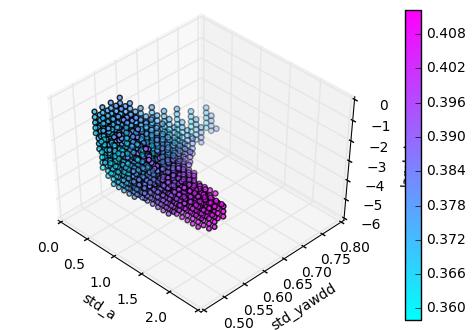

In [13]:
def average_rmse(rmses):
    return np.sqrt(np.dot(rmses, rmses) / len(rmses))
    
def plot_in_parameter_space(results, size_scale=30):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    data = np.array([
        [
            dict(key)['std_a'],
            dict(key)['std_yawdd'],
            dict(key)['lambd'],
            size_scale * np.mean(make_nis_vector(value, 'kl_div')),
            average_rmse(make_rmse_vector(value))
        ]
        for key, value in results.items()
    ])
    p = ax.scatter(data[:,0], data[:,1], data[:,2],
                   s=data[:,3], c=data[:,4], cmap='cool')
    ax.set_xlabel('std_a')
    ax.set_ylabel('std_yawdd')
    ax.set_zlabel('lambda')
    ax.view_init(elev=45, azim=-45)
    fig.colorbar(p)
    
plot_in_parameter_space(RESULTS_IN_SPEC)

#### Plot in Objective Space (3D)

If we average the RMSEs for position across both datasets and the RMSEs for speed across both datasets, and we the KL-div consistency score, that also gives us three axes. Even showing only the Pareto frontier, there are still a lot of solutions to worry about; the 2D versions of these plots below, in which all RMSEs are averaged, are I think more useful.

,std_a,std_yawdd,lambda,average NIS kl_div,average position RMSE,average speed RMSE
15,0.673684,0.573945,-4.947368,0.362015,0.144177,0.524638
9,0.578947,0.573945,-4.947368,0.366853,0.143662,0.517574
24,0.673684,0.552688,-4.684211,0.368870,0.144462,0.516531
17,0.484211,0.596903,-4.947368,0.369071,0.142793,0.512599
18,0.578947,0.552688,-4.684211,0.376018,0.143999,0.510514
20,0.484211,0.648807,-4.947368,0.376099,0.142183,0.519427
25,0.389474,0.596903,-4.947368,0.377134,0.142310,0.504292
27,0.484211,0.532949,-4.421053,0.378787,0.143960,0.501029
29,0.389474,0.621774,-4.947368,0.381172,0.142015,0.506598
0,0.484211,0.552688,-4.684211,0.381631,0.143516,0.504268


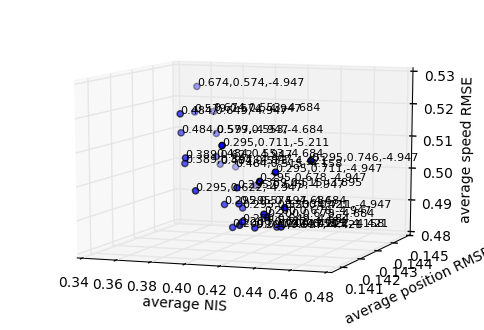

In [14]:
def make_position_rmse_vector(values):
    return np.concatenate([
        make_single_position_rmse_vector(values[1]),
        make_single_position_rmse_vector(values[2])
    ])

def make_speed_rmse_vector(values):
    return np.concatenate([
        make_single_speed_rmse_vector(values[1]),
        make_single_speed_rmse_vector(values[2])
    ])

def plot_in_3d_objective_space(results, consistency_score, pareto_only):
    keys = list(results.keys())
    values = [results[key] for key in keys]
    data = np.array([
        [
            np.mean(make_nis_vector(value, consistency_score)),
            average_rmse(make_position_rmse_vector(value)),
            average_rmse(make_speed_rmse_vector(value))
        ]
        for value in values
    ])
    
    frontier = None
    if pareto_only:
        indexes = [
            i
            for i in range(len(keys))
            if not any (
                np.all(data[j,:] < data[i,:])
                for j in range(len(keys))
            )
        ]
        frontier = pd.DataFrame([
            (
                key_i['std_a'], key_i['std_yawdd'], key_i['lambd'],
                data[i,0], data[i,1], data[i,2]
            )
            for i in indexes
            for key_i in [dict(keys[i])]
        ], columns=(
            'std_a', 'std_yawdd', 'lambda',
            'average NIS ' + consistency_score,
            'average position RMSE', 'average speed RMSE'
        )).sort_values('average NIS ' + consistency_score)
    else:
        indexes = range(len(keys))        
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(data[indexes,0], data[indexes,1], data[indexes,2])
    ax.set_xlabel('average NIS')
    ax.set_ylabel('average position RMSE')
    ax.set_zlabel('average speed RMSE')
    ax.view_init(elev=10, azim=-70)

    for i in indexes:
        key = dict(keys[i])
        text = "{std_a:.3f},{std_yawdd:.3f},{lambd:.3f}".format(**key)
        ax.text(data[i,0], data[i,1], data[i,2], text, size=8)
    return frontier
    
plot_in_3d_objective_space(RESULTS_IN_SPEC, 'kl_div', pareto_only=True)

#### Plot in Objective Space (2D)

,std_a,std_yawdd,lambda,average NIS kl_div,average RMSE
5,0.673684,0.573945,-4.947368,0.362015,0.384728
2,0.578947,0.573945,-4.947368,0.366853,0.379817
10,0.673684,0.552688,-4.684211,0.368870,0.379258
6,0.484211,0.596903,-4.947368,0.369071,0.376263
7,0.578947,0.552688,-4.684211,0.376018,0.375073
11,0.389474,0.596903,-4.947368,0.377134,0.370515
12,0.484211,0.532949,-4.421053,0.378787,0.368615
9,0.484211,0.514571,-4.157895,0.382494,0.367557
13,0.294737,0.621774,-4.947368,0.390935,0.365830
0,0.389474,0.514571,-3.894737,0.397966,0.364123


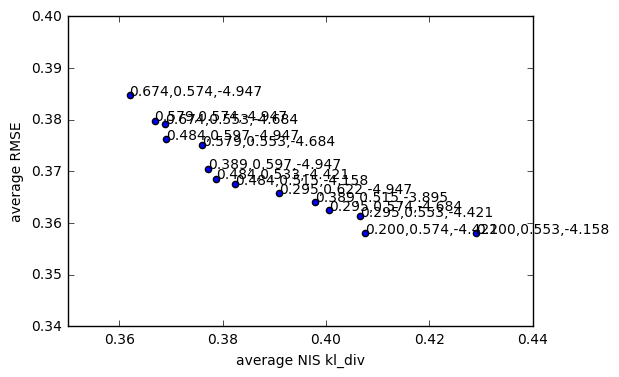

In [15]:
def plot_in_objective_space(results, consistency_score, pareto_only):
    keys = list(results.keys())
    values = [results[key] for key in keys]
    data = np.array([
        [
            np.mean(make_nis_vector(value, consistency_score)),
            average_rmse(make_rmse_vector(value))
        ]
        for value in values
    ])
    
    frontier = None
    if pareto_only:
        indexes = [
            i
            for i in range(len(keys))
            if not any (
                np.all(data[j,:] < data[i,:])
                for j in range(len(keys))
            )
        ]
        frontier = pd.DataFrame([
            (
                key_i['std_a'], key_i['std_yawdd'], key_i['lambd'],
                data[i,0], data[i,1]
            )
            for i in indexes
            for key_i in [dict(keys[i])]
        ], columns=(
            'std_a', 'std_yawdd', 'lambda',
            'average NIS ' + consistency_score, 'average RMSE'
        )).sort_values('average NIS ' + consistency_score)
    else:
        indexes = range(len(keys))        
    
    fig, ax = plt.subplots()
    ax.scatter(data[indexes,0], data[indexes,1])
    
    for i in indexes:
        key = dict(keys[i])
        text = "{std_a:.3f},{std_yawdd:.3f},{lambd:.3f}".format(**key)
        ax.annotate(text, (data[i,0], data[i,1]))
    
    plt.xlabel('average NIS ' + consistency_score)
    plt.ylabel('average RMSE')
    
    return frontier
plot_in_objective_space(RESULTS_IN_SPEC, 'kl_div', pareto_only=True)

#### Weighted Solution Scoring

One way to pick a solution from the 2D plot above is to assign weights to average RMSE and NIS KL-div, and then minimise. I picked the one with equal weighting as the default; it's the fourth point from the top left in the plot above.

In [16]:
def find_weighted_score(value, rmse_weight,
                        consistency_weight, consistency_score):
    consistency = np.mean(make_nis_vector(value, consistency_score))
    # Want to be as close to 0.95 as possible.
    if consistency_score == 'quantile':
        consistency = np.abs(consistency - 0.95)
    return \
        rmse_weight * average_rmse(make_rmse_vector(value)) + \
        consistency_weight * consistency
    
def find_top_results(
    results, n,
    rmse_weight=1,
    consistency_weight=1,
    consistency_score='kl_div'):
    sorted_results = sorted(
        results.items(),
        key=lambda pair: find_weighted_score(
            pair[1], rmse_weight, consistency_weight, consistency_score))
    return [
        (value, dict(key))
        for key, value in sorted_results
    ][0:n]
find_top_results(RESULTS_IN_SPEC, 3)

[({1: {'laser_nis_kl_div': 0.45860637727020176,
    'laser_nis_quantile': 1.0,
    'px_rmse': 0.0713093,
    'py_rmse': 0.0881498,
    'radar_nis_kl_div': 0.23371139797882495,
    'radar_nis_quantile': 0.82516339869281041,
    'vx_rmse': 0.588449,
    'vy_rmse': 0.586656},
   2: {'laser_nis_kl_div': 0.28183054117133066,
    'laser_nis_quantile': 1.0,
    'px_rmse': 0.181626,
    'py_rmse': 0.188988,
    'radar_nis_kl_div': 0.50213377088216948,
    'radar_nis_quantile': 0.98999999999999999,
    'vx_rmse': 0.363591,
    'vy_rmse': 0.477906}},
  {'lambd': -4.947368421052632,
   'std_a': 0.4842105263157895,
   'std_yawdd': 0.5969026041820606,
   'use_laser': True,
   'use_radar': True}),
 ({1: {'laser_nis_kl_div': 0.41902762294623103,
    'laser_nis_quantile': 1.0,
    'px_rmse': 0.0736873,
    'py_rmse': 0.0891843,
    'radar_nis_kl_div': 0.23475693436514264,
    'radar_nis_quantile': 0.82352941176470584,
    'vx_rmse': 0.592772,
    'vy_rmse': 0.590099},
   2: {'laser_nis_kl_div': 0.3047